Source repository: https://github.com/avehtari/BDA_py_demos

This notebook contains some Python demos for the book [Bayesian Data
Analysis, 3rd ed by Gelman, Carlin, Stern, Dunson, Vehtari, and Rubin (BDA3)](http://www.stat.columbia.edu/~gelman/book/). See also [Bayesian Data Analysis course material](https://github.com/avehtari/BDA_course_Aalto).

Currently there are demos for BDA3 Chapters 2, 3, 4, 5, 6, 10 and 11. Furthermore, [PyStan](https://github.com/stan-dev/pystan) is also demoed.

Demos are in jupyter notebook (.ipynb) format. These can be directly previewed in github without need
to install or run anything.

Corresponding demos were originally written for [Matlab/Octave](https://github.com/avehtari/BDA_m_demos) by [Aki Vehtari](http://users.aalto.fi/~ave/) and translated to Python by Tuomas Sivula. Some improvements were contributed by Pellervo Ruponen and Lassi Meronen. There are also corresponding [R demos](https://github.com/avehtari/BDA_R_demos).

### Bayesian data analysis
##  Chapter 11, demo 2

Metropolis sampling demonstration

First we import required libraries and tune some settings

In [3]:
import numpy as np
from scipy import linalg, stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import arviz as az

In [4]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [5]:
# edit default plot settings
plt.rc('font', size=12)

## Example 1

We create a two dimensional normal distribution to be used as an example target distribution. We also define the starting values for the Metropolis sampling here.

In [6]:
# parameters of a two dimensional Normal distribution used as a toy target distribution
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
r = 0.8  # covariance between the first and second dimension
S = np.array([[1.0, r], [r, 1.0]]) # covariance within both dimensions is 1.0

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension
# number of iterations.
M = 5000

Next we apply Metropolis sampling to sample the generated two dimensional normal distribution. We sample from the toy distribution to visualize 90% HPD (Highest Posterior Density) interval. See BDA3 p. 85 for how to compute HPD for a multivariate normal distribution. In 2d-case contour for 90% HPD is an ellipse, whose semimajor axes can be computed from the eigenvalues of the covariance matrix scaled by a value selected to get ellipse match the density at the edge of 90% HPD. Angle of the ellipse could be computed from the eigenvectors, but since the marginals are same we know that angle is pi/4.

In [7]:
# Metropolis sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# For demonstration, load pre-computed values.
# Replace this with your algorithm!
# tt is a M x 2 array, with M samples of both theta_1 and theta_2
res_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'demo11_2a.csv'
    )
)
res = np.loadtxt(res_path, skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))

loaded pre-computed values in variable `tt`
shape:(5000, 2), dtype:float64


The rest is just for illustration. We first calculate the 90% HPD using the covariance matrix.

In [8]:
# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

# number of samples to discard from the beginning
burnin = 500

# Plot 90% HPD.
# In 2d-case contour for 90% HPD is an ellipse, whose semimajor
# axes can be computed from the eigenvalues of the covariance
# matrix scaled by a value selected to get ellipse match the
# density at the edge of 90% HPD. Angle of the ellipse could be 
# computed from the eigenvectors, but since marginals are same
# we know that angle is 45 degrees.
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) # 2.147 is the value to get the ellipse match the 
                                                                # density at the edge of 90% HPD

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

We show the sequential progress of the sampling for the first 500 samples. These 500 samples are then removed as burnin from the final samples. Finally we also plot the rest of the samples that remain after the burnin has been removed.

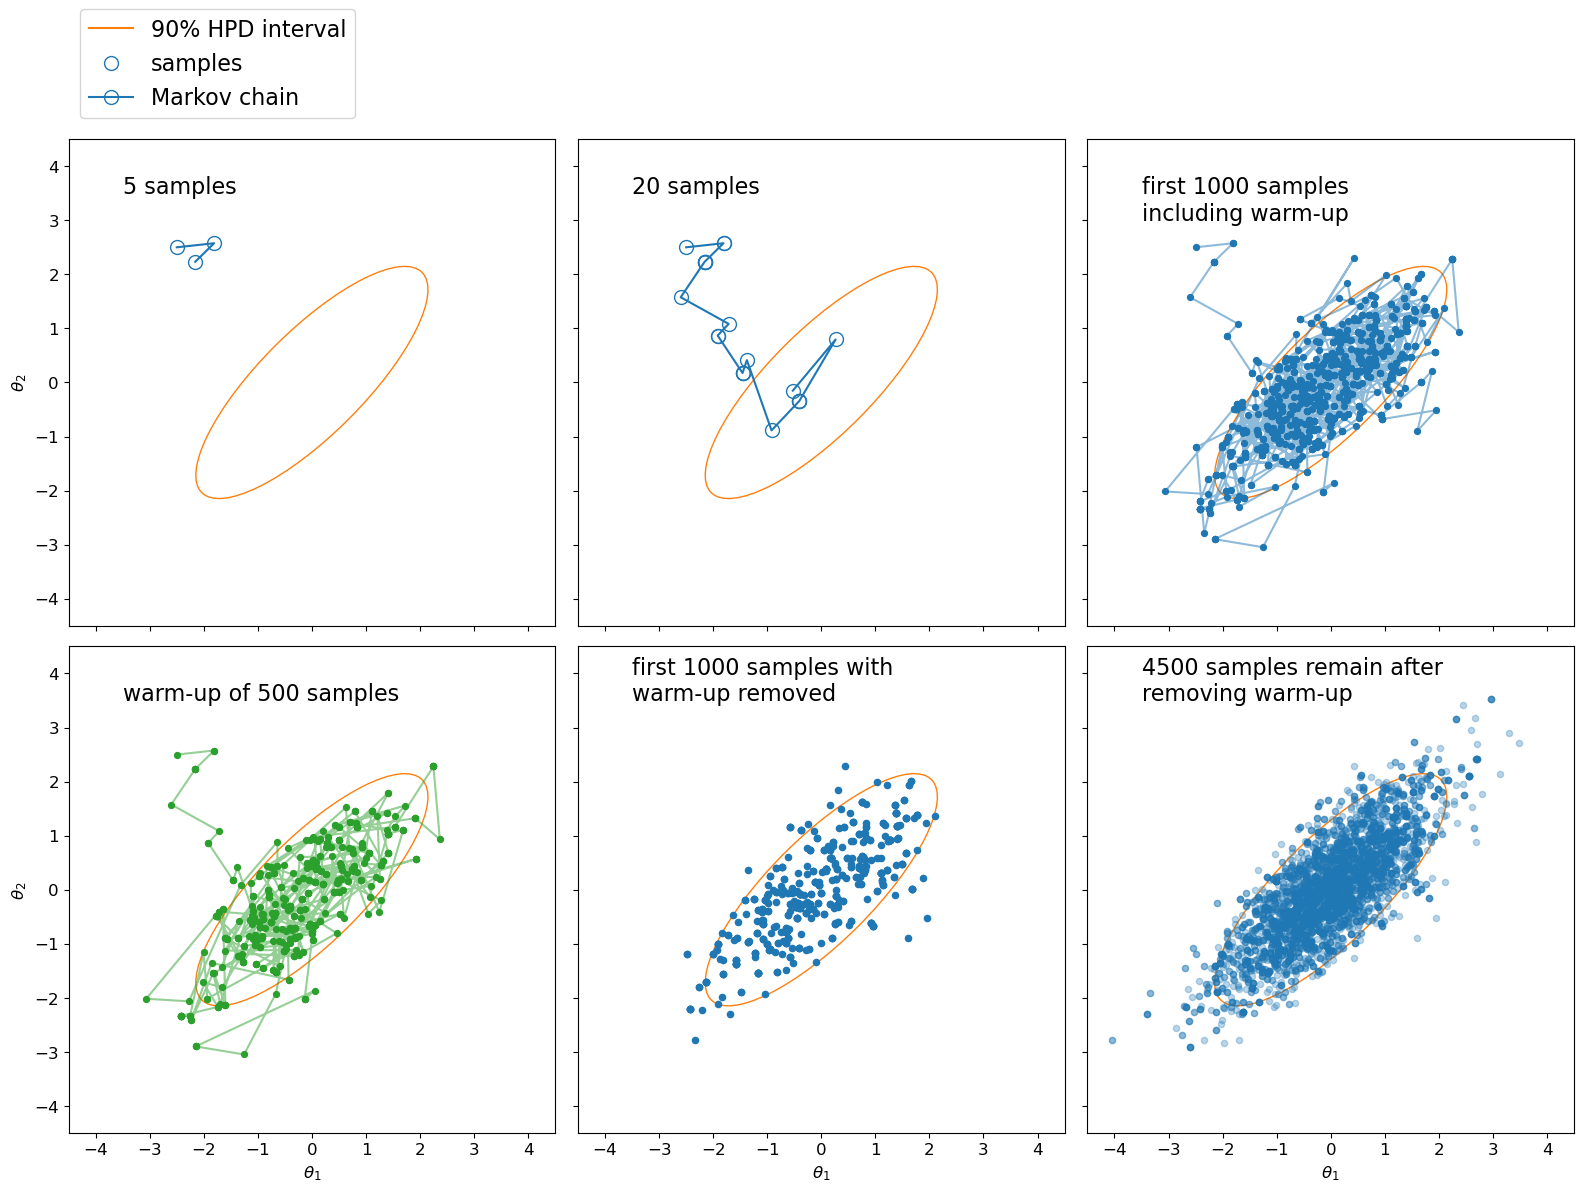

In [9]:
# create the plots
subplotshape = (2, 3)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(16,12), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)


# FIRST SUBPLOT
ax = axes[0,0]
add90hpd(ax)
i = 5
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')
ax.text(-3.5, 3.5, '5 samples', fontsize=16)

# SECOND SUBPLOT
ax = axes[0,1]
add90hpd(ax)
i = 20
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '20 samples', fontsize=16)

# THIRD SUBPLOT
ax = axes[0,2]
add90hpd(ax)
i = 1000
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1,0], tt[:i+1,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 1000 samples\nincluding warm-up', fontsize=16)

#FOURTH SUBPLOT
ax = axes[1,0]
add90hpd(ax)
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin,0], tt[:burnin,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 500 samples', fontsize=16)

# FIFTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 999
ax.scatter(
    tt[burnin:i+1,0], tt[burnin:i+1,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 1000 samples with\nwarm-up removed', fontsize=16)

# SIXTH SUBPLOT
ax = axes[1,2]
add90hpd(ax)
ax.scatter(
    tt[burnin:,0], tt[burnin:,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '4500 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

Looking at the last sublot showing the 4500 samples after removing warm-up, we can see that the sampling seems to have sampled the target distribution quite well. All of the 90% HPD area is sampled and also about 10% of the samples seem to fall outside of the 90% HPD. Notice, that for example in the first subplot it looks like only 3 samples are shown. This is because in Metropolis sampling the previous sample is taken as a new sample if the other candidate for the new sample is not accepted. In the first subplot we have accepted the new sample twice and taken the old sample as the new sample twice. Overlapping samples can't be seen in the plot, so this leads to the plot showing only two new samples after the starting point.

We'll next plot an animation showing the first 500 samples of the Metropolis sampling. This animation requires ffmpeg in order to work properly. If you need to install ffmpeg, the instructions can be found at https://www.wikihow.com/Install-FFmpeg-on-Windows. If the animation doesn't play correctly, you can also find the animation from the same folder as this demo with the filename "metropolissampler1.mp4". Notice that the animation seems to sometimes pause at some samples for a small time. This is because the previous sample has been sampled again when the candidate sample was rejected.

RuntimeError: Requested MovieWriter (ffmpeg) not available

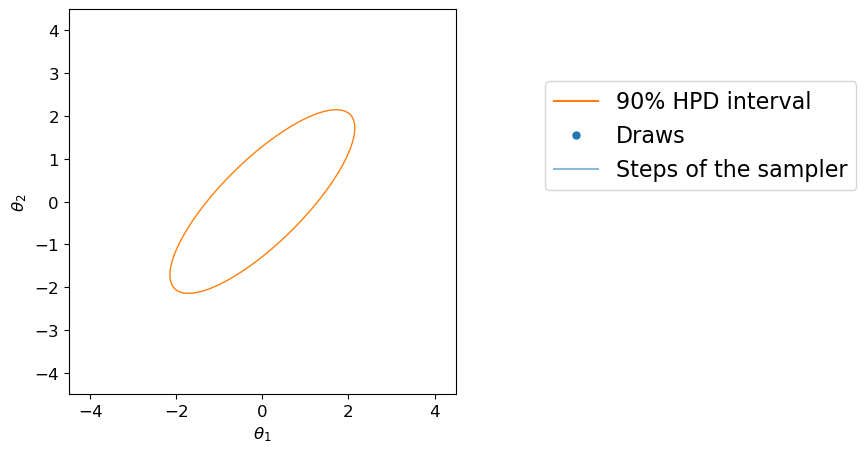

In [10]:
# First set up the figure, the axis and the axis labels
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
ax.set_ylabel(r'$\theta_2$')
ax.set_xlabel(r'$\theta_1$')

# Plot a legend
ax.legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=5,
            markerfacecolor='C0', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='C0', alpha=0.5),
    ),
    (   '90% HPD interval',
        'Draws',
        'Steps of the sampler'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(1.2, 0.5, 0, 0),
    fontsize=16
)

# Initialize styles for the lines and points to be plotted. At this point the lines and points have no data.
line, = ax.plot([], [], color='C0', alpha=0.5)
point, = ax.plot([], [],'.', markersize=10, lw=0, markerfacecolor='C0', markeredgecolor='C0')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    point.set_data([], [])
    return (line,point,)


add90hpd(ax) #draw the 90% HPD

#choose only the warmup samples
warmup1 = tt[:burnin,0]
warmup2 = tt[:burnin,1]


# animation function. This is called sequentially
def animate(i):
    x = warmup1[:i] #choose points until i
    y = warmup2[:i] #choose points until i
    line.set_data(x, y) #draw lines between all points  
    point.set_data(x, y) #draw points for every other sample
    return (line,point,)

# choose the animation writer. If you don't have ffmpeg installed you can change this to some writer that you already have.
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=100, blit=True)

# show the animation as a html5 video to allow showing it in an iPython notebook
HTML(anim.to_html5_video())

# Uncomment below to save the animation as an mp4-file

# #Save the movie file
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('metropolissampler1.mp4', writer=writer)




## Convergence diagnostics

Here we show the $\hat{R}$ and ESS for $\theta\$ using the ArviZ library. 

In [11]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,-0.006,0.968,-1.735,1.914,0.048,0.034,414.0,586.0,1.01


## Visual convergence diagnostics

Here we plot the behavior of theta1 and theta2 separately. We also plot the cumulative average and autocorrelation for theta1 and theta2 samples separately to visually see the convergence.

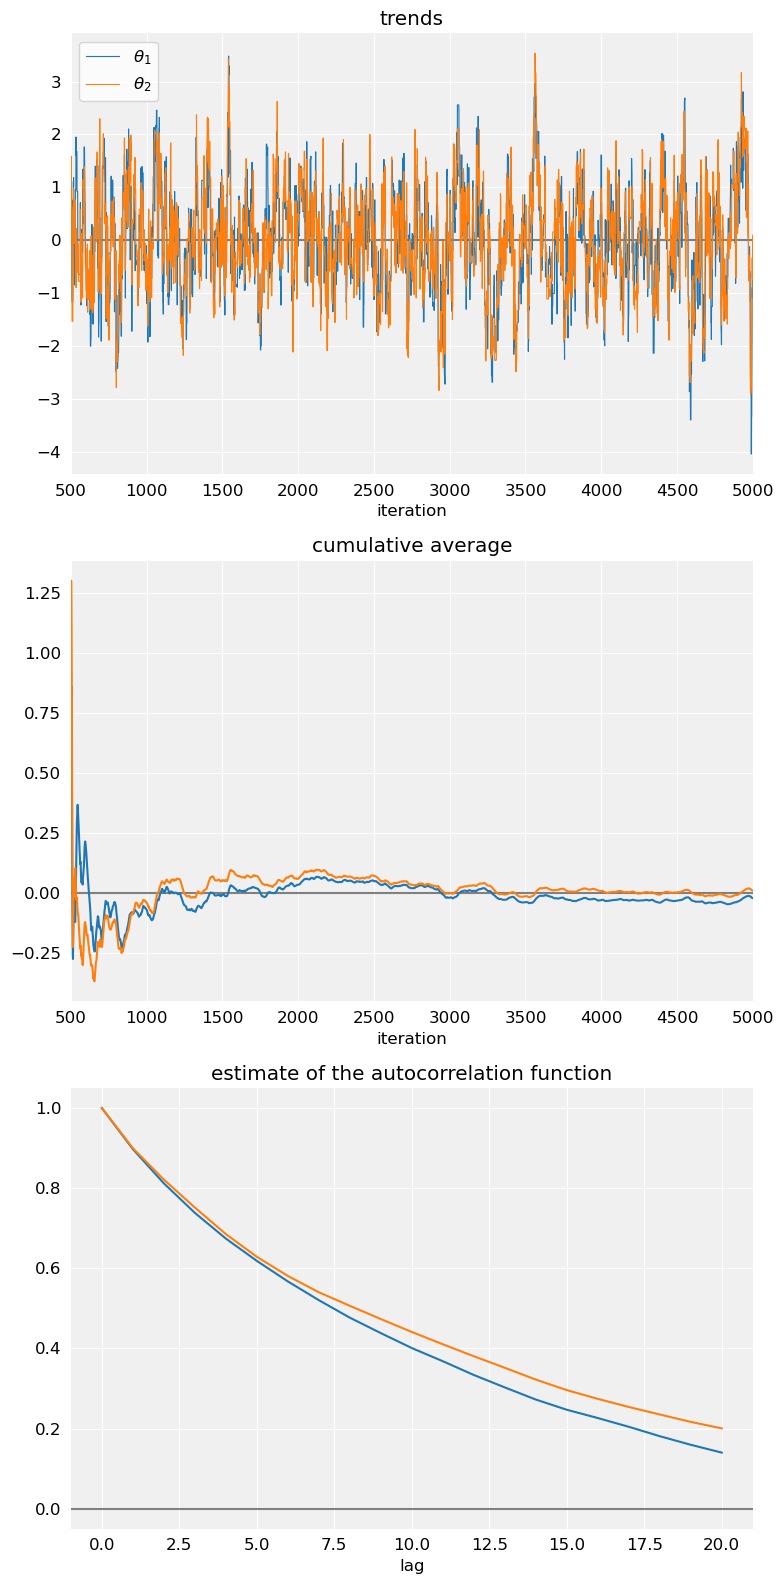

In [12]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M)
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin, 5000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin, 5000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

Looking at the trends we can see that the sampling moves around the distribution quite rapidly. Looking at the cumulative average we can see that the chains seem to converge. Looking at the estimated autocorrelation function we can see that there's not too much autocorrelation once the lag is increased.

Next we visualize the estimate of the Monte Carlo error estimates for the cumulative average plots.

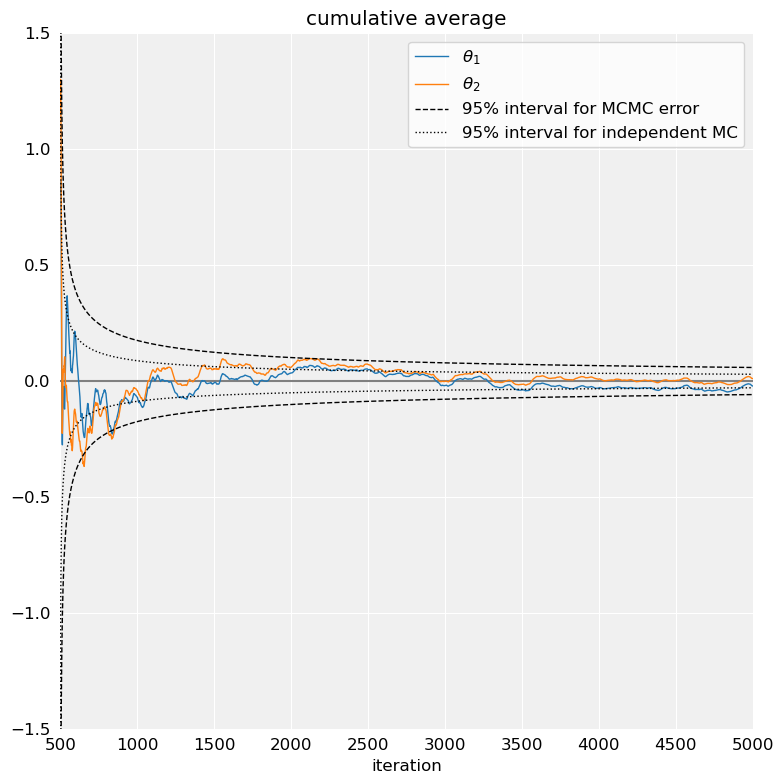

In [13]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin, 5000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

The analysis and the generated samples both show that Metropolis sampling worked quite well for the target distribution that we used. Next we'll test the same Metropolis sampling for a more narrow two dimensional normal distribution.

## Example 2

Now our target distribution will be a two dimensional normal distribution with r = 0.99. This makes the distribution much narrower.

In [ ]:
# parameters of a two dimensional Normal distribution used as a toy target distribution
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
r = 0.99  # covariance between the first and second dimension
S = np.array([[1.0, r], [r, 1.0]]) # covariance within both dimensions is 1.0

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension
# number of iterations.
M = 5000

Next we apply Metropolis sampling to sample the generated two dimensional normal distribution. We sample from the toy distribution to visualize 90% HPD (Highest Posterior Density) interval. See BDA3 p. 85 for how to compute HPD for a multivariate normal distribution. In 2d-case contour for 90% HPD is an ellipse, whose semimajor axes can be computed from the eigenvalues of the covariance matrix scaled by a value selected to get ellipse match the density at the edge of 90% HPD. Angle of the ellipse could be computed from the eigenvectors, but since the marginals are same we know that angle is pi/4.

In [13]:
# Metropolis sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# For demonstration, load pre-computed values.
# Replace this with your algorithm!
# tt is a M x 2 array, with M samples of both theta_1 and theta_2
res_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'demo11_2b.csv'
    )
)
res = np.loadtxt(res_path, skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))

loaded pre-computed values in variable `tt`
shape:(5000, 2), dtype:float64


The rest is just for illustration. We first calculate the 90% HPD using the covariance matrix.

In [14]:
# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

# number of samples to discard from the beginning
burnin = 500

# Plot 90% HPD.
# In 2d-case contour for 90% HPD is an ellipse, whose semimajor
# axes can be computed from the eigenvalues of the covariance
# matrix scaled by a value selected to get ellipse match the
# density at the edge of 90% HPD. Angle of the ellipse could be 
# computed from the eigenvectors, but since marginals are same
# we know that angle is 45 degrees.
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) # 2.147 is the value to get the ellipse match the 
                                                                # density at the edge of 90% HPD

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

We show the sequential progress of the sampling for the first 500 samples. These 500 samples are then removed as burnin from the final samples. Finally we also plot the rest of the samples that remain after the burnin has been removed.

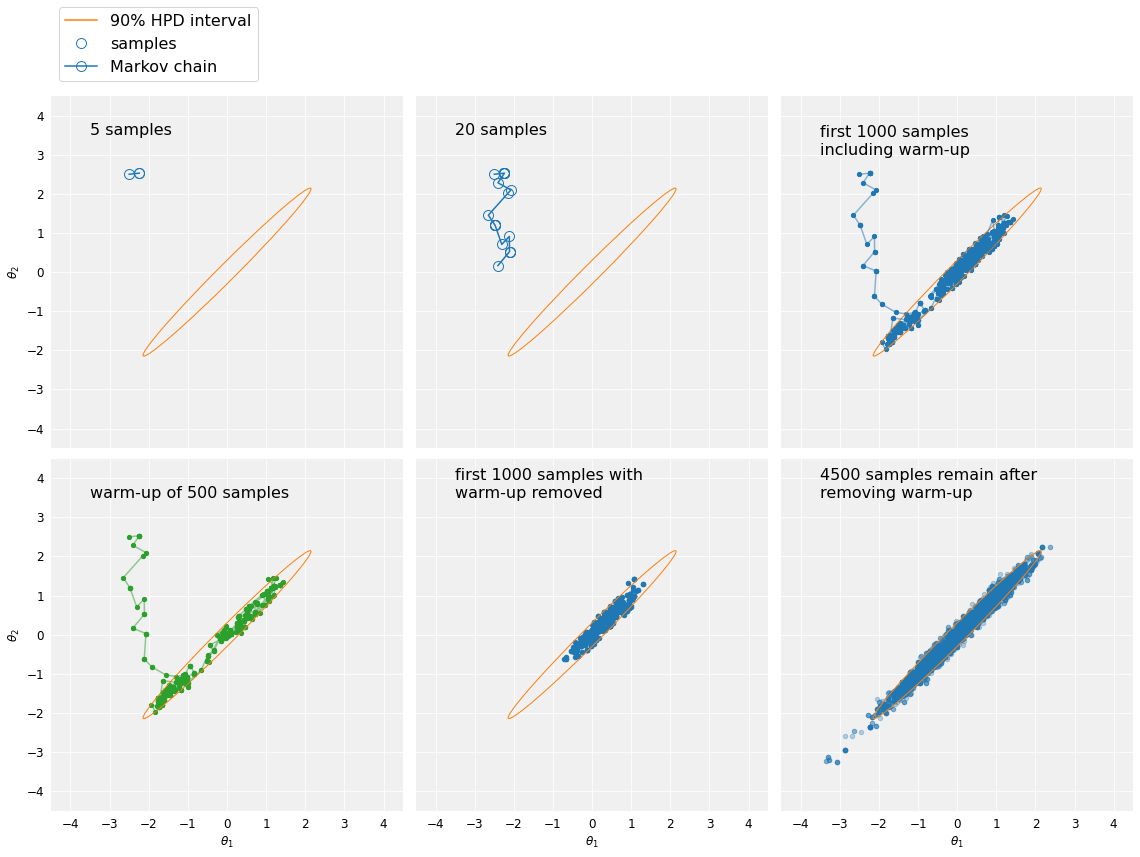

In [15]:
# create the plots
subplotshape = (2, 3)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(16,12), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)


# FIRST SUBPLOT
ax = axes[0,0]
add90hpd(ax)
i = 5
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')
ax.text(-3.5, 3.5, '5 samples', fontsize=16)

# SECOND SUBPLOT
ax = axes[0,1]
add90hpd(ax)
i = 20
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '20 samples', fontsize=16)

# THIRD SUBPLOT
ax = axes[0,2]
add90hpd(ax)
i = 1000
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1,0], tt[:i+1,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 1000 samples\nincluding warm-up', fontsize=16)

#FOURTH SUBPLOT
ax = axes[1,0]
add90hpd(ax)
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin,0], tt[:burnin,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 500 samples', fontsize=16)

# FIFTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 999
ax.scatter(
    tt[burnin:i+1,0], tt[burnin:i+1,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 1000 samples with\nwarm-up removed', fontsize=16)

# SIXTH SUBPLOT
ax = axes[1,2]
add90hpd(ax)
ax.scatter(
    tt[burnin:,0], tt[burnin:,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '4500 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

Looking at the last sublot showing the 4500 samples after removing warm-up, we can see that the sampling seems to have sampled the target distribution at least quite well. There are samples all around the 90% HPD. We need further diagnostics to actually see if the sampling is good. Notice, that for example in the first subplot it looks like only 3 samples are shown. This is because in Metropolis sampling the previous sample is taken as a new sample if the other candidate for the new sample is not accepted. In the first subplot we have accepted the new sample twice and taken the old sample as the new sample twice. Overlapping samples can't be seen in the plot, so this leads to the plot showing only two new samples after the starting point.

We'll next plot an animation showing the first 500 samples of the Metropolis sampling. This animation requires ffmpeg in order to work properly. If you need to install ffmpeg, the instructions can be found at https://www.wikihow.com/Install-FFmpeg-on-Windows. If the animation doesn't play correctly, you can also find the animation from the same folder as this demo with the filename "metropolissampler2.mp4". Notice that the animation seems to sometimes pause at some samples for a small time. This is because the previous sample has been sampled again when the candidate sample was rejected.

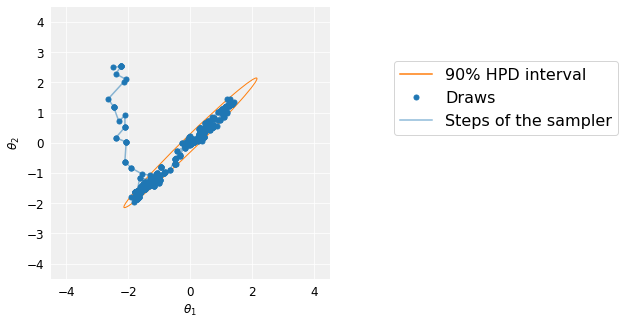

In [16]:
# First set up the figure, the axis and the axis labels
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
ax.set_ylabel(r'$\theta_2$')
ax.set_xlabel(r'$\theta_1$')

# Plot a legend
ax.legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=5,
            markerfacecolor='C0', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='C0', alpha=0.5),
    ),
    (   '90% HPD interval',
        'Draws',
        'Steps of the sampler'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(1.2, 0.5, 0, 0),
    fontsize=16
)

# Initialize styles for the lines and points to be plotted. At this point the lines and points have no data.
line, = ax.plot([], [], color='C0', alpha=0.5)
point, = ax.plot([], [],'.', markersize=10, lw=0, markerfacecolor='C0', markeredgecolor='C0')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    point.set_data([], [])
    return (line,point,)


add90hpd(ax) #draw the 90% HPD

#choose only the warmup samples
warmup1 = tt[:burnin,0]
warmup2 = tt[:burnin,1]


# animation function. This is called sequentially
def animate(i):
    x = warmup1[:i] #choose points until i
    y = warmup2[:i] #choose points until i
    line.set_data(x, y) #draw lines between all points  
    point.set_data(x, y) #draw points for every other sample
    return (line,point,)

# choose the animation writer. If you don't have ffmpeg installed you can change this to some writer that you already have.
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=100, blit=True)

# show the animation as a html5 video to allow showing it in an iPython notebook
HTML(anim.to_html5_video())

# Uncomment below to save the animation as an mp4-file

# #Save the movie file
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('metropolissampler2.mp4', writer=writer)




## Convergence diagnostics

Here we show the $\hat{R}$ and ESS for $\theta\$ using the ArviZ library. 

In [17]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\theta$,0.038,0.967,-1.596,1.725,0.108,0.077,80.0,80.0,82.0,168.0,1.04


## Visual convergence diagnostics

Here we plot the behavior of theta1 and theta2 separately. We also plot the cumulative average and autocorrelation for theta1 and theta2 samples separately to visually see the convergence.

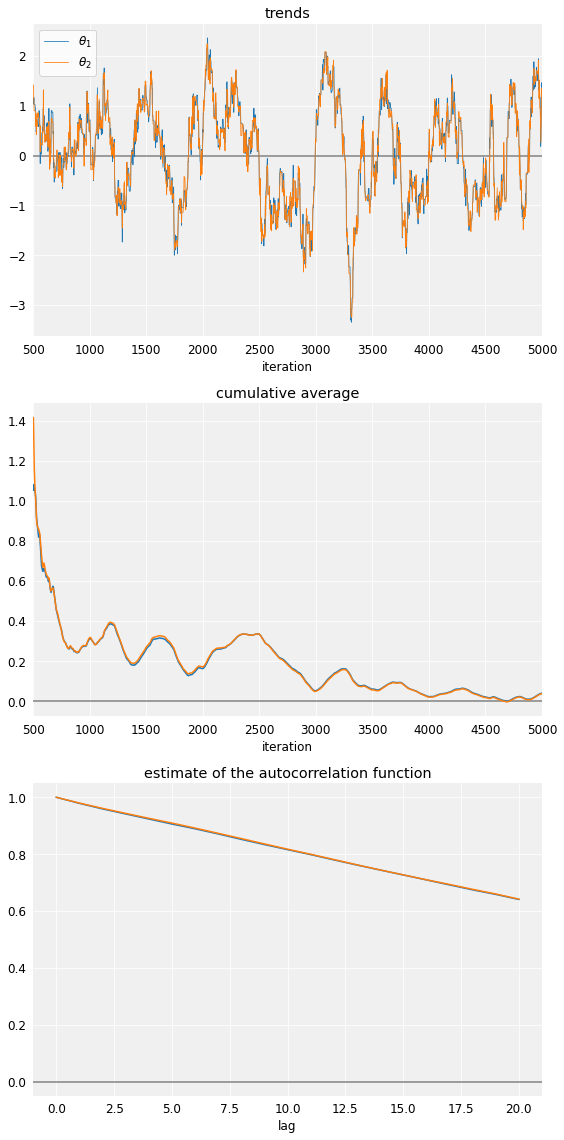

In [18]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

# Plotting trends for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin, 5000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin, 5000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

Looking at the trend curves we can see that the sampling moves around the target distribution quite slowly. Looking at the cumulative average we can see that the chains only start to converge very late. We need at least the 5000 samples to have a relatively good convergence. Looking at the estimated autocorrelation function we can see that significant autocorrelation remains until lag 20.

Next we visualize the estimate of the Monte Carlo error estimates for the cumulative average plots.

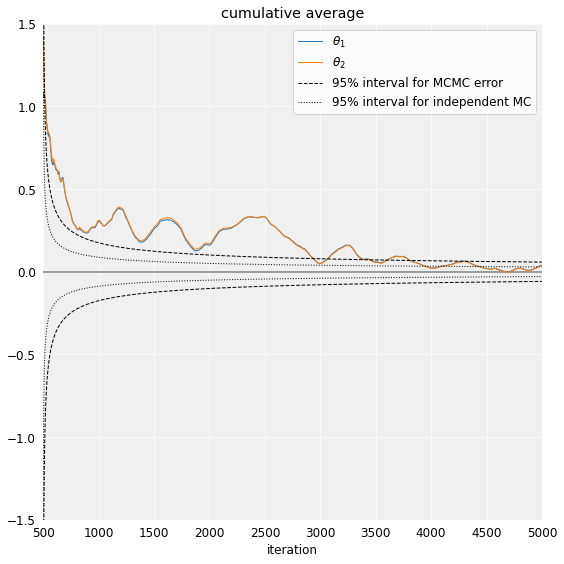

In [19]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin, 5000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

The analysis and the generated samples both show that Metropolis sampling didn't work very well for the chosen target distribution. For this target distribution we should consider some other sampling method or at least generate a very large number of samples to have a correct distribution of samples.